In [1]:
using CairoMakie
using CSV
using DataFrames
using MLJ
using MLJBase

In [2]:
# Import training dataset
lichen_training = CSV.read("C:/Users/julio/Downloads/lichen_training.csv", DataFrame, missingstring="NA") |>
x -> DataFrames.select(x, "Total.lichen", "basal_area", "PL", "mean_Long", "mean_Lat", "Aspect_south", "SNR", "SMR", "SX") |>
x -> rename(x, ["biomass", "basalarea", "pl", "lon", "lat", "south", "snr", "smr", "sx"]) |>
dropmissing |>
x -> coerce(x, :pl=>Continuous, :sx=>Continuous, :snr=>Multiclass, :smr=>Multiclass);

In [3]:
# schema 
schema(lichen_training)

┌───────────┬───────────────────────────────────┬───────────────┐
│ _.names   │ _.types                           │ _.scitypes    │
├───────────┼───────────────────────────────────┼───────────────┤
│ biomass   │ Float64                           │ Continuous    │
│ basalarea │ Float64                           │ Continuous    │
│ pl        │ Float64                           │ Continuous    │
│ lon       │ Float64                           │ Continuous    │
│ lat       │ Float64                           │ Continuous    │
│ south     │ Float64                           │ Continuous    │
│ snr       │ CategoricalValue{String1, UInt32} │ Multiclass{3} │
│ smr       │ CategoricalValue{Int64, UInt32}   │ Multiclass{5} │
│ sx        │ Float64                           │ Continuous    │
└───────────┴───────────────────────────────────┴───────────────┘
_.nrows = 77


In [4]:
# Split predictors/responde variable
y, X = unpack(lichen_training, ==(:biomass), _->true; rng=1010);

([2.43, 0.34, 1.72, 288.4, 1.49, 1917.77, 254.57, 3044.13, 1.55, 67.36  …  41.94, 3209.72, 294.86, 1.93, 794.04, 2.99, 523.83, 50.19, 1164.63, 21.75], 77×8 DataFrame
 Row │ basalarea  pl       lon       lat      south    snr   smr   sx      
     │ Float64    Float64  Float64   Float64  Float64  Cat…  Cat…  Float64 
─────┼─────────────────────────────────────────────────────────────────────
   1 │     31.17     78.0  -124.62   56.2372     1.0   C     4         0.0
   2 │     30.08     50.0  -125.133  56.0107     0.55  C     3         0.0
   3 │     22.54      0.0  -124.625  55.4193     0.39  C     4        60.0
   4 │     11.71     79.0  -125.446  56.0079     0.59  B     3         0.0
   5 │     24.79     80.0  -125.487  55.7387     0.67  C     4         0.0
   6 │     19.94    100.0  -124.691  55.6586     0.78  B     4         0.0
   7 │     27.86      0.0  -125.83   55.807      0.96  B     4         0.0
   8 │      2.49    100.0  -124.244  55.5477     0.43  C     3         0.0
  ⋮  │

In [5]:
# Load a model and create a pipeline
model = @load RandomForestRegressor pkg=DecisionTree verbosity=0
pipe = @pipeline Standardizer OneHotEncoder model target=v->log.(v) inverse=v->exp.(v)

┌ Info: Treating pipeline as a `Deterministic` predictor.
│ To override, specify `prediction_type=...` (options: :deterministic, :probabilistic, :interval). 
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\composition\models\pipelines.jl:372


Pipeline281(
    standardizer = Standardizer(
            features = Symbol[],
            ignore = false,
            ordered_factor = false,
            count = false),
    one_hot_encoder = OneHotEncoder(
            features = Symbol[],
            drop_last = false,
            ordered_factor = true,
            ignore = false),
    random_forest_regressor = RandomForestRegressor(
            max_depth = -1,
            min_samples_leaf = 1,
            min_samples_split = 2,
            min_purity_increase = 0.0,
            n_subfeatures = -1,
            n_trees = 10,
            sampling_fraction = 0.7,
            pdf_smoothing = 0.0,
            rng = Random._GLOBAL_RNG()),
    target = WrappedFunction(
            f = var"#11#12"()),
    inverse = WrappedFunction(
            f = var"#13#14"()))

In [ ]:
# Model tunning
# r = [
#      range(pipe, :(random_forest_regressor.max_depth), lower=1, upper=5),
#      range(pipe, :(random_forest_regressor.n_trees), lower=10, upper=20)
# ]

# tuned_model = TunedModel(
#      model=pipe,
#      tuning=Grid(resolution=20),
#      resampling=CV(),
#      range=r,
#      measures=mae,
#      train_best=true
# )

# m = machine(tuned_model, X, y) |> fit!


In [6]:

# Create a machine
pipe.random_forest_regressor.n_trees = 50
m = machine(pipe, X, y)

Machine{Pipeline281,…} trained 0 times; caches data
  args: 
    1:	Source @034 ⏎ `Table{Union{AbstractVector{Continuous}, AbstractVector{Multiclass{3}}, AbstractVector{Multiclass{5}}}}`
    2:	Source @964 ⏎ `AbstractVector{Continuous}`


In [7]:
# Evaluate the model
evaluate!(
    m,
    resampling=CV(nfolds=10),
    measure=[mae, rms],
    verbosity=0
)

PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌────────────────────────┬─────────────┬───────────┬────────────────────────────
│ measure                │ measurement │ operation │ per_fold                  ⋯
├────────────────────────┼─────────────┼───────────┼────────────────────────────
│ MeanAbsoluteError()    │ 559.0       │ predict   │ [620.0, 680.0, 393.0, 625 ⋯
│ RootMeanSquaredError() │ 956.0       │ predict   │ [1170.0, 1120.0, 524.0, 1 ⋯
└────────────────────────┴─────────────┴───────────┴────────────────────────────
                                                                1 column omitted


In [8]:
# Fit the model
fit!(m)

# Check fitted parameters
fp = fitted_params(m)

┌ Info: Training Machine{Pipeline281,…}.
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:403
┌ Info: Training Machine{WrappedFunction,…}.
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:403
┌ Info: Training Machine{Standardizer,…}.
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:403
┌ Info: Training Machine{WrappedFunction,…}.
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:403
┌ Info: Training Machine{OneHotEncoder,…}.
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:403
┌ Info: Spawning 3 sub-features to one-hot encode feature :snr.
└ @ MLJModels C:\Users\julio\.julia\packages\MLJModels\GKDnU\src\builtins\Transformers.jl:1142
┌ Info: Spawning 5 sub-features to one-hot encode feature :smr.
└ @ MLJModels C:\Users\julio\.julia\packages\MLJModels\GKDnU\src\builtins\Transformers.jl:1142
┌ Info: Training Machine{RandomForestRegressor,…}.
└ @ MLJBase C:\Users\julio\.ju

(inverse = (fitresult = nothing,),
 random_forest_regressor = (forest = Ensemble of Decision Trees
Trees:      50
Avg Leaves: 38.7
Avg Depth:  10.4,),
 one_hot_encoder = (fitresult = OneHotEncoderResult,),
 standardizer = Dict(:basalarea => (19.90597402597402, 9.59526339559761), :sx => (9.883116883116884, 23.760301935201667), :lat => (55.97332400649351, 0.5664634649325856), :pl => (57.05194805194805, 43.025052709193105), :south => (0.7041558441558441, 0.19658499333253884), :lon => (-125.32716337662336, 0.881650658304238)),
 target = (fitresult = nothing,),
 machines = Machine[Machine{WrappedFunction,…}, Machine{Standardizer,…}, Machine{OneHotEncoder,…}, Machine{RandomForestRegressor,…}, Machine{WrappedFunction,…}],
 fitted_params_given_machine = LittleDict{Any, Any, Vector{Any}, Vector{Any}}(Machine{WrappedFunction,…} => (fitresult = nothing,), Machine{Standardizer,…} => Dict(:basalarea => (19.90597402597402, 9.59526339559761), :sx => (9.883116883116884, 23.760301935201667), :lat => (5

In [10]:
m.report

(machines = Machine[Machine{WrappedFunction,…}, Machine{Standardizer,…}, Machine{OneHotEncoder,…}, Machine{RandomForestRegressor,…}, Machine{WrappedFunction,…}],
 report_given_machine = LittleDict{Any, Any, Vector{Any}, Vector{Any}}(Machine{WrappedFunction,…} => nothing, Machine{Standardizer,…} => (features_fit = [:basalarea, :sx, :lat, :pl, :south, :lon],), Machine{OneHotEncoder,…} => (features_to_be_encoded = [:snr, :smr], new_features = [:basalarea, :pl, :lon, :lat, :south, :snr__A, :snr__B, :snr__C, :smr__2, :smr__3, :smr__4, :smr__5, :smr__6, :sx]), Machine{RandomForestRegressor,…} => NamedTuple(), Machine{WrappedFunction,…} => nothing),)

In [12]:
ŷ = predict(m);

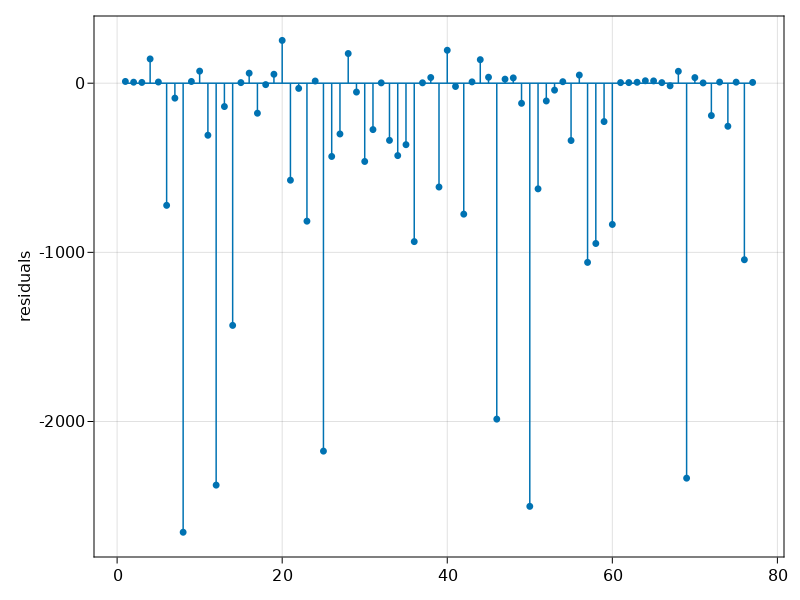

In [13]:
f = Figure()

ax1 = Axis(f[1, 1])
ax1.ylabel = "residuals"
stem!(ax1, ŷ - y)

# ax2 = Axis(f[2, 1])
# ax2.xlabel = "max_depth"
# ax2.ylabel = "mae"
# scatter!(ax2, Float64.(m.report.plotting.parameter_values[:, 1]), m.report.plotting.measurements)

# ax3 = Axis(f[3, 1])
# ax3.xlabel = "n_trees"
# ax3.ylabel = "mae"
# scatter!(ax3, Float64.(m.report.plotting.parameter_values[:, 2]), m.report.plotting.measurements)

f

In [15]:
@show rms(ŷ, y)
@show mae(ŷ, y);

rms(ŷ, y) = 759.3089616601005
mae(ŷ, y) = 397.7461170969398


In [16]:
results = vcat(
    hcat(fill(1, length(ŷ)), ŷ),
    hcat(fill(2, length(y)), y)
)

154×2 Matrix{Float64}:
 1.0    11.7823
 1.0     5.25457
 1.0     5.27638
 1.0   430.871
 1.0     7.46584
 1.0  1194.63
 1.0   165.269
 1.0   388.421
 1.0    10.6976
 1.0   137.759
 ⋮    
 2.0  3209.72
 2.0   294.86
 2.0     1.93
 2.0   794.04
 2.0     2.99
 2.0   523.83
 2.0    50.19
 2.0  1164.63
 2.0    21.75

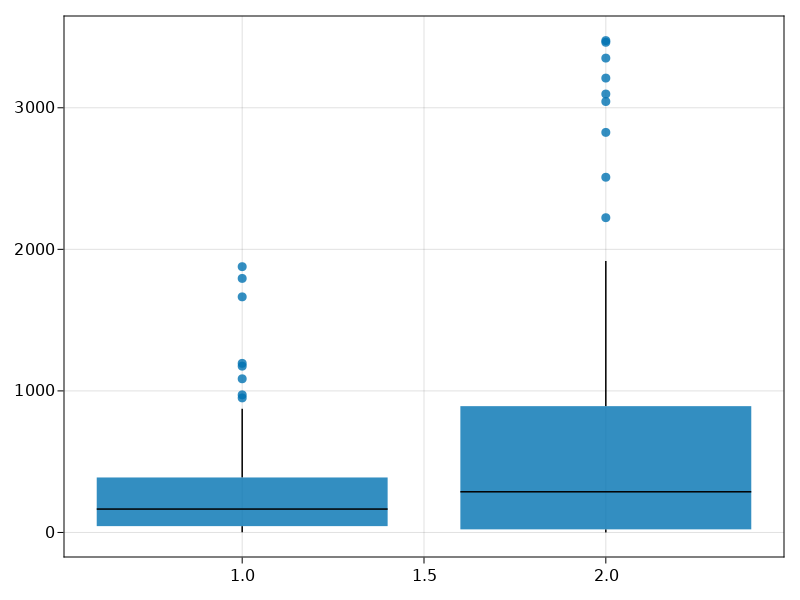

In [19]:
f = Figure()

ax1 = Axis(f[1, 1])
boxplot!(ax1, results[:, 1], results[:, 2])

f

# Predict on new dataset

In [ ]:
# Import CSV to dataframe, select the same columns used for training
lichen = CSV.read("C:/Users/julio/Downloads/predicted_biomass_Nov2021.csv", DataFrame) |>
x -> select(x, :BASAL_AREA, :PL, :LON) |>
x -> rename(x, ["basalarea", "pl", "lon"]);

In [ ]:
# Predict on a new dataset
biomass = exp.(predict(m, lichen))

In [ ]:
# Combine new dataset with predictions
results = hcat(lichen, biomass)

In [ ]:
# Export results to CSV
CSV.write("C:/Users/julio/Downloads/predicted_biomass_rf.csv", results)